split worldmap for robinson with different ref point  
a preparation for drawing with draw_3_b.ipynb

In [29]:
from collections import defaultdict
import vmapper
import os
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.ops import transform, split
import shapely
from pyproj import Transformer, CRS, Proj

import matplotlib.pyplot as plt
import seaborn as sns

from catppuccin_palette import catppuccin as cpc
import mplcatppuccin
from mplcatppuccin.palette import load_color
from mplcatppuccin.colormaps import get_colormap_from_list
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
#from jinja2 import Environment, PackageLoader, select_autoescape
import jinja2
from tqdm.notebook import tqdm

/home/benny/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/geopandas/geodataframe.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[exploded_geom.name] = exploded_geom.values
/tmp/ipykernel_356384/2728975135.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf3['area'] = gdf3.area


<Axes: >

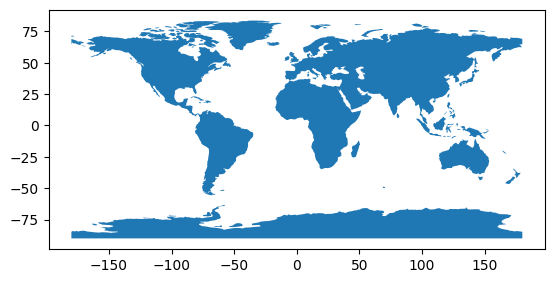

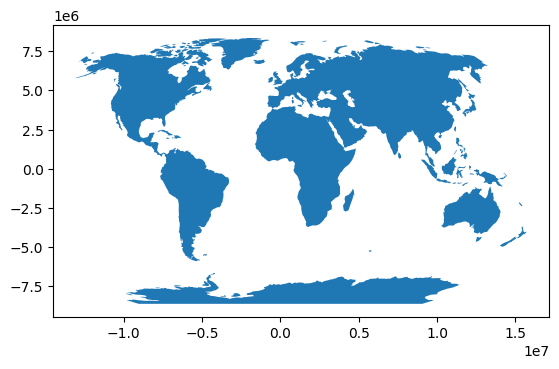

In [2]:
fp = '../data/natural_earth/ne_110m_admin_0_countries2.shp'
#fp = 'data/natural_earth/ne_110m_land.shp'
gdf = gpd.read_file(fp)
gdf2 = gdf.dissolve().explode(index_parts=True)
gdf3 = gdf2[['featurecla', 'geometry']].copy()
gdf3['area'] = gdf3.area
gdf4 = gdf3[gdf3['area']>1]
gdf4 = gdf4.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
gdf4.plot()
#gdf.plot()
this_crs = '+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' # robinson
gdf4.to_crs(this_crs).plot()

In [23]:
projections = {}

for x in [x*30 for x in range(12)]:
    if x>180:
        x-=180
        x = -180+x
    x2 = 'E{}'.format(x) if x>0 else 'W{}'.format(abs(x)) if x<0 else 'EW{}'.format(x)
    n = x2
    #print(n)
    this_crs = '+proj=robin +lon_0={} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' .format(x)
    projections[n] = (this_crs, x)
    #print(this_crs)
    #gdf4.to_crs(this_crs).plot(fc='none', ec='k')
    #grid.to_crs(this_crs).plot(fc='none', ec='k')
len(projections)


12

In [55]:
lon0s = []
for x in [x*30 for x in range(12)]:
    if x>180:
        x-=180
        x = -180+x
    lon0s.append(x)

In [56]:
lon0s

[0, 30, 60, 90, 120, 150, 180, -150, -120, -90, -60, -30]

In [79]:
split_lines = []
for lon0 in lon0s:
    y = -100
    if lon0>=0:
        opposite = lon0 - 180
    else:
        opposite = lon0 + 180
    x1 = opposite+0.01  # right
    x2 = opposite-0.01  # left
    x3 = opposite # center
    #print(lon0, x3)
    #print(x1, x2, x3)

    line1 = []
    line2 = []
    line3 = []
    for i in range(1, 40):
        # go north
        y = y + 5
        line1.append((x1, y))
        line2.append((x2, y))
        line3.append((x3, y))

    line1 = LineString(line1)  # right
    line2 = LineString(line2)  # left
    line3 = LineString(line3)  # center
    split_lines.append((line1, line2, line3))

In [80]:
gdf4

,id,featurecla,geometry,area
0,0,Admin-0 country,"POLYGON ((-163.71290 -78.59567, -163.71290 -78...",3.716703
1,1,Admin-0 country,"POLYGON ((-122.40624 -73.32462, -121.21151 -73...",1.541898
2,2,Admin-0 country,"POLYGON ((-100.78346 -72.50162, -101.80187 -72...",3.004556
3,3,Admin-0 country,"POLYGON ((-78.18210 8.31918, -78.43547 8.38771...",4158.334445
4,4,Admin-0 country,"POLYGON ((-128.35841 50.77065, -127.30858 50.5...",4.056773
...,...,...,...,...
87,87,Admin-0 country,"POLYGON ((139.81754 42.56376, 140.31209 43.333...",9.979769
88,88,Admin-0 country,"POLYGON ((143.50528 46.13791, 142.74770 46.740...",10.600657
89,89,Admin-0 country,"POLYGON ((140.81171 73.76506, 142.06207 73.857...",1.628959
90,90,Admin-0 country,"POLYGON ((147.97746 74.77836, 146.11919 75.172...",2.006982


In [136]:
tmp = gdf4.copy()
tmp['cat'] = 9999
tmp['alt_x'] = None
tmp['alt_y'] = None

print(len(tmp))
for lon0, slines in zip(lon0s, split_lines):
    line1, line2, line3 = slines
    tmp2 = tmp.copy()

    geoms = []
    for i in range(len(tmp2)):
        row = tmp2.iloc[i]
        poly = row['geometry']
        split_polys = split(poly, line1)
        split_polys = [p for p in split_polys.geoms]
        if len(split_polys)==1:
            gs = split_polys
            new_poly = Polygon(gs[0])
            geoms.append({'geometry': new_poly, 'cat': row['cat'], 
                          'alt_x': row['alt_x'], 'alt_y': row['alt_y']})
        else:
            #print(len(split_polys))
            gs = []
            for p in split_polys:
                tmp3 = split(p, line2)
                tmp3 = [p for p in tmp3.geoms]
                #print(len(tmp3))
                gs.extend(tmp3)
            #gs2 = []
            #gs3 = []
            for g in gs:
                if not(g.intersects(line3)):
                    #gs2.append(g)
                    new_poly = Polygon(g)
                    geoms.append({'geometry': new_poly, 'cat': -9999, 
                                  'alt_x': None, 'alt_y': None})
                else:
                    #gs3.append(g)  # need to be hidden
                    new_poly = Polygon(g)
                    left_pt = sorted([p for p in new_poly.exterior.coords])[0]
                    #print(, lon0)
                    #alt_pt = Point(left_pt)#.buffer(0.0001).exterior.coords
                    geoms.append({'geometry': new_poly, 'cat': lon0, 
                                  'alt_x': left_pt[0], 'alt_y': left_pt[1]})  
                    # hide when lon0 is the ref line
            #print(len(gs), len(gs2))
            #new_poly = MultiPolygon(gs2)
        #geoms.append(new_poly)
    #tmp2['geometry'] = geoms
    #tmp2 = tmp.explode(index_parts=False)
    tmp4 = pd.DataFrame(geoms)
    tmp4 = gpd.GeoDataFrame(tmp4, crs=gdf4.crs)
    #print(tmp4)
    #tmp4.plot()
    tmp = tmp4
    print(len(tmp))
    #break
gdf5 = tmp
gdf5 = gdf5.reset_index().rename(columns={'index': 'id'})

92
95
103
113
129
145
153
163
172
178
182
198
213


In [137]:
#gdf5

<Axes: >

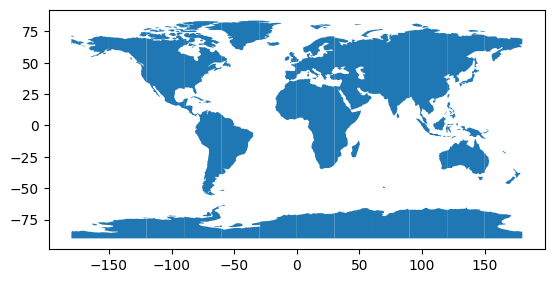

In [138]:
gdf5.plot()

In [139]:
gdf5['cat'].unique()

array([ 9999, -9999,    60,   120,    90,    30,     0,   180,  -150,
        -120,   -90,   -60,   -30,   150])

213


<Axes: >

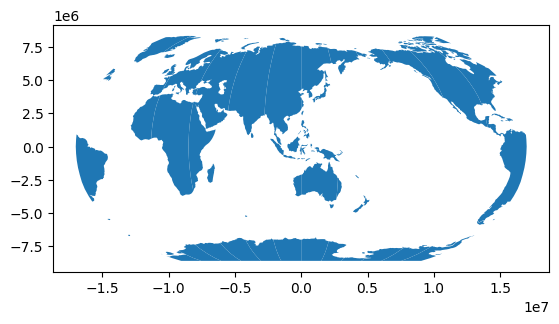

In [140]:
k = 'E120'

crs, lon0 = projections[k]

the_gdf = gdf5[gdf5['cat']!=lon0].copy()
alt_gdf = gdf5[gdf5['cat']==lon0].copy()
#alt_gdf = alt_gdf.set_geometry('alt')
#alt_gdf.crs = gdf5.crs
tmp_geom = [Point(altx, alty).buffer(0.0001) for altx, alty in zip(alt_gdf['alt_x'], alt_gdf['alt_y'])]
alt_gdf['geometry'] = tmp_geom
the_gdf = pd.concat([the_gdf, alt_gdf])

the_gdf = the_gdf.to_crs(crs)

print(len(the_gdf))

the_gdf.plot(lw=0, ec='none')


213


<Axes: >

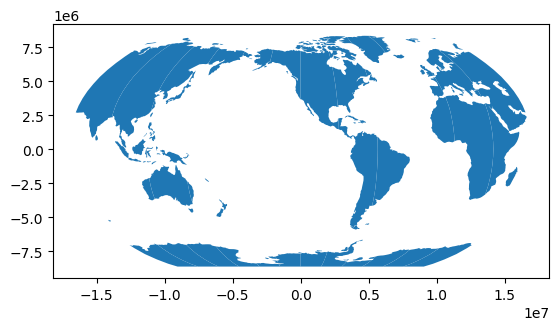

In [141]:
k = 'W120'

crs, lon0 = projections[k]

the_gdf = gdf5[gdf5['cat']!=lon0].copy()
alt_gdf = gdf5[gdf5['cat']==lon0].copy()
#alt_gdf = alt_gdf.set_geometry('alt')
#alt_gdf.crs = gdf5.crs
tmp_geom = [Point(altx, alty).buffer(0.0001) for altx, alty in zip(alt_gdf['alt_x'], alt_gdf['alt_y'])]
alt_gdf['geometry'] = tmp_geom
the_gdf = pd.concat([the_gdf, alt_gdf])

the_gdf = the_gdf.to_crs(crs)

print(len(the_gdf))

the_gdf.plot(lw=0, ec='none')


In [142]:
gdf5.head()

,id,geometry,cat,alt_x,alt_y
0,0,"POLYGON ((-163.71290 -78.59567, -163.71290 -78...",9999,NaN,NaN
1,1,"POLYGON ((-122.40624 -73.32462, -121.21151 -73...",-9999,NaN,NaN
2,2,"POLYGON ((-120.01000 -73.64667, -119.99000 -73...",60,-120.01,-74.028602
3,3,"POLYGON ((-119.99000 -73.64910, -119.91885 -73...",-9999,NaN,NaN
4,4,"POLYGON ((-100.78346 -72.50162, -101.80187 -72...",9999,NaN,NaN


In [143]:
gdf5.to_file('../data/natural_earth/ne_110m_admin_0_countries2_robin.shp')